# GAN: Generative Adversarial Network

GANs were first proposed by [Goodfellow, 2014](https://arxiv.org/pdf/1406.2661) as a framework for building a Neural Network capable of generating data that approximates the distribution of a given training set.

## 1. Overview

The idea of GANs is to pitch two networks against each other:
- A generative network $G$ that takes dummy data from some artificial distribution to the training set domain
- A discriminator network $D$ that is trained to detect whether a given data comes from $G$ or the training set

By training these networks in tandem, a good discriminator forces the generator to be even better and vice-versa. After some iterations, we should have a generator that can confidently convert dummy data (e.g., noise) to data points that closely resembles the training set.

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
from  torch.utils.data import DataLoader, Subset
from tqdm import tqdm

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
indices = [i for i, label in enumerate(mnist_dataset.targets) if label in [0]]
mnist_dataset = Subset(mnist_dataset, indices)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
print(f"Size of the Dataset: {len(mnist_dataset)} | Number of Batches: {len(dataloader)}")

Size of the Dataset: 5923 | Number of Batches: 93


# 2. Generator, $G$

The generator is built to take random vectors $z$ to vectors $x = G(z)$ that are in the training set domain (e.g., 1x784 for MNIST).

In this simple example, we build it as a MLP with ReLU activation.

In [238]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.image_dim = image_dim
        self.main = nn.Sequential(

             # Start with a linear layer to project the random vector
            nn.Linear(latent_dim, 2*latent_dim),
            nn.ReLU(True),

            # Start with a linear layer to project the random vector
            nn.Linear(2*latent_dim, 128 * (image_dim-2) * (image_dim-2)),
            nn.ReLU(True),
            
            nn.Dropout(0.2),
            
            # Reshape into a 2D feature map
            nn.Unflatten(1, (128, (image_dim-2), (image_dim-2))),

            nn.Dropout(0.2),

            # Upsample to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Dropout(0.2),

            # Final layer to output a 1-channel image
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.main(noise)
    
    def generate(self):
        noise = torch.randn(1,self.latent_dim)
        return self(noise).view(self.image_dim, self.image_dim).detach()

# 3. Discriminator, $D$

In [239]:
class Discriminator(nn.Module):
    def __init__(self, image_dim=28):
        super(Discriminator, self).__init__()
        self.image_dim = image_dim
        self.model = nn.Sequential(

            # First linear layer
            nn.Conv2d(1,4,3, padding='same'),
            nn.MaxPool2d(2,2),
            nn.ReLU(),

            nn.Conv2d(4,8,3, padding='same'),
            nn.MaxPool2d(2,2),
            nn.ReLU(),

            nn.Conv2d(8,16,3, padding='same'),
            nn.MaxPool2d(2,2),
            nn.ReLU(),

            nn.Conv2d(16,32,3, padding='same'),
            nn.MaxPool2d(2,2),
            nn.ReLU(),

            nn.Flatten(),

            # Second linear layer
            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# 4. Training

In [240]:
latent_dim = 100
image_dim = 28

generator = Generator(latent_dim, image_dim)
discriminator = Discriminator(image_dim=image_dim)

# --- Loss Function and Optimizers ---
# Binary Cross-Entropy loss is commonly used for GANs
adversarial_loss = nn.BCELoss()

# Adam optimizer for both networks
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

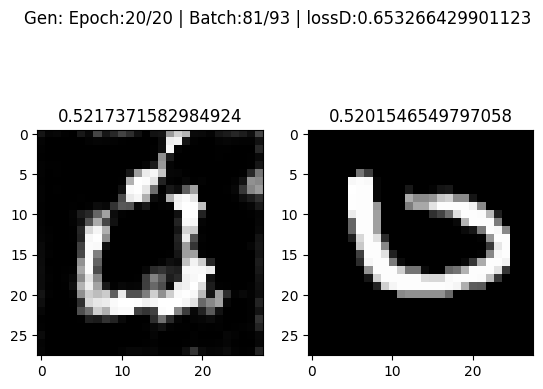

93it [00:12,  7.37it/s]

Training finished.


In [241]:
iter = []
isGen = []
pctFake = []

n_epochs = 20
KDisc = 40
KGen = 20

j=0
k=0
    
for epoch in range(n_epochs):
    for i, (imgs, _) in tqdm(enumerate(dataloader)):

        real_imgs = imgs.view(imgs.size(0), 1, image_dim, image_dim)
        real_labels = torch.full((imgs.size(0), 1), 1.0) # Label for real images (1)
        fake_labels = torch.full((imgs.size(0), 1), 0.0) # Label for fake images (0)

        if k<= KDisc:

            generator.eval()
            discriminator.train()

            output_real = discriminator(real_imgs)
            loss_D_real = adversarial_loss(output_real, real_labels)
            noise = torch.rand(imgs.size(0), latent_dim)
            
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach()) # Detach to prevent gradients flowing to generator
            loss_D_fake = adversarial_loss(output_fake, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2
            optimizer_D.zero_grad()
            loss_D.backward() # Backpropagate
            optimizer_D.step() # Update discriminator weights

            title =  f"DISC: Epoch:{epoch+1}/{n_epochs} | Batch:{i+1}/{len(dataloader)} | lossD:{loss_D.item()}"
            k+=1

        elif (k>KGen) & (k<=KDisc + KGen):
             
            generator.train()
            discriminator.eval()
            
            noise = torch.rand(imgs.size(0), latent_dim)
            gen_imgs = generator(noise) # Use the same noise for consistency in this iteration
            output_gen = discriminator(gen_imgs)
            loss_G = adversarial_loss(output_gen, real_labels)
            optimizer_G.zero_grad()
            loss_G.backward() # Backpropagate
            optimizer_G.step() # Update generator weights

            title =  f"Gen: Epoch:{epoch+1}/{n_epochs} | Batch:{i+1}/{len(dataloader)} | lossD:{loss_G.item()}"
            k+=1

        else:
             k=0

        iter.append(j)
        pctFake.append(output_fake.mean().item())
        isGen.append(0)
        j += 1
        if i%20==0:
            clear_output()
            noise = torch.rand(1, latent_dim)
            img = generator(noise)
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(img.detach().view(image_dim, image_dim), cmap='gray')
            ax[1].imshow(real_imgs[0].view(image_dim,image_dim), cmap='gray')
            pred = discriminator(img)
            ax[0].set_title(pred.item())
            pred = discriminator(real_imgs[0:1])
            ax[1].set_title(pred.item())
            fig.suptitle(title)
            plt.show()




    # pbar.set_postfix(f"Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(dataloader)}] Loss D: {loss_D.item():.4f} Loss G: {loss_G.item():.4f}")

print("Training finished.")

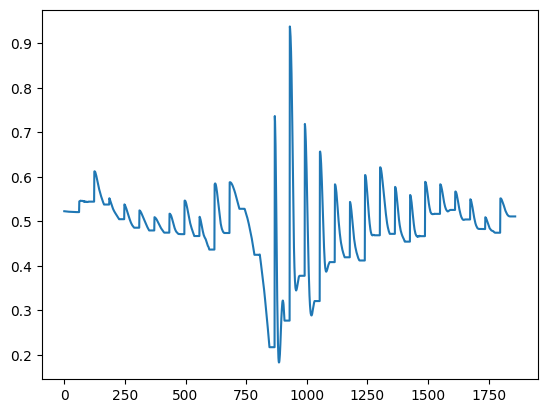

In [242]:
plt.plot(iter, pctFake)
